In [127]:
from mp_api.client import MPRester
from mp_api.client.routes.materials.elasticity import ElasticityRester
import tqdm,os
import numpy as np


In [1]:
import os

env_var = os.environ.get("MP_API_KEY")
print(env_var)


None


Download all elasticity data from materials project

- beware that GPT autocomplete is biased by legacy API! The suggestions do not work!

In [76]:
mpr = ElasticityRester(API_KEY)
elastic_data = mpr.search(fields=['elastic_tensor','shear_modulus','bulk_modulus','structure','nelements'])

Retrieving ElasticityDoc documents: 100%|██████████| 12392/12392 [00:23<00:00, 524.10it/s]


Filter all single element systems and extract 6x6 elastic constant tensor

In [111]:
elastic_tensors = []
for m in tqdm.tqdm(elastic_data):
    if m.nelements>1: 
        continue
    if m.elastic_tensor is not None:
        C11 = m.elastic_tensor.ieee_format[0][0]
        if C11<1e5 and C11>0.0: # sanity check
            elastic_tensors += [m.elastic_tensor.ieee_format]
elastic_tensors = np.array(elastic_tensors)
print(f"""
Elastic Tensors Shape: {elastic_tensors.shape}
""")    

100%|██████████| 12392/12392 [00:00<00:00, 3202847.87it/s]


Elastic Tensors Shape: (281, 6, 6)



Select cubic-like materials

In [125]:
# select cubic-like materials
select = np.isclose(elastic_tensors[:,0,0],elastic_tensors[:,1,1],rtol=1e-2)
select *= np.isclose(elastic_tensors[:,0,0],elastic_tensors[:,2,2],rtol=1e-2)
select *= np.isclose(elastic_tensors[:,3,3],elastic_tensors[:,4,4],rtol=1e-2)
select *= np.isclose(elastic_tensors[:,3,3],elastic_tensors[:,5,5],rtol=1e-2)
select *= np.isclose(elastic_tensors[:,3,4],0.0,rtol=1e-2)
select *= np.isclose(elastic_tensors[:,3,5],0.0,rtol=1e-2)
select *= np.isclose(elastic_tensors[:,4,5],0.0,rtol=1e-2)
select *= elastic_tensors[:,4,4]>0.0 

Plot C11 vs C12 and C44 with correlations

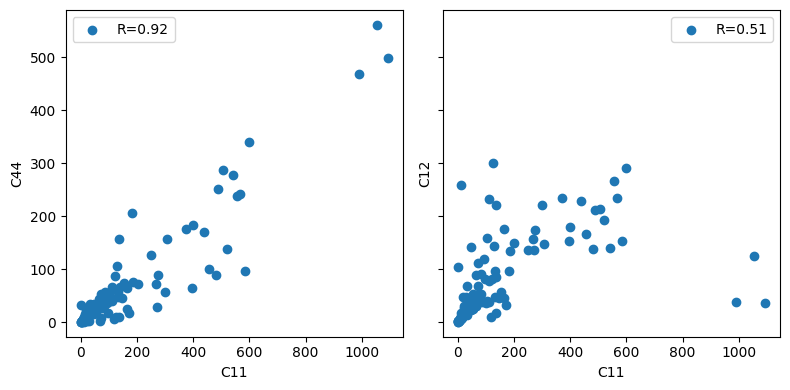

In [126]:
import matplotlib.pyplot as plt



fig,axs = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)

x=elastic_tensors[select,0,0]
y=elastic_tensors[select,3,3]
R = np.corrcoef(x,y)
axs[0].scatter(x,y,label=f"R={R[0,1]:.2f}")

x=elastic_tensors[select,0,0]
y=elastic_tensors[select,0,1]
R = np.corrcoef(x,y)
axs[1].scatter(x,y,label=f"R={R[0,1]:.2f}")


axs[0].set_xlabel("C11")
axs[1].set_xlabel("C11")
axs[0].set_ylabel("C44")
axs[1].set_ylabel("C12")
axs[0].legend()
axs[1].legend()

plt.tight_layout()
